RUBY -O369974
INDIVIDUYAL ASSIGNMENT


In [1]:
#importing neccesary libraries for assignment
import pandas as pd
import numpy as np
import time
from google.colab import files
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import r2_score, accuracy_score, precision_score, recall_score, classification_report
import time
from joblib import Parallel, delayed


In [2]:
#step-1 loading dataset
#loading the dataset we are about to work with
df = pd.read_csv("/content/mlpcDATASET.csv")

df.head()


,latitude,longitude,brightness,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_t31,frp,daynight
0,67.59621,83.24409,334.38,0.52,0.67,6/30/2025,3,N,VIIRS,n,2.0NRT,284.05,4.39,D
1,67.59536,83.24015,331.72,0.52,0.67,6/30/2025,3,N,VIIRS,n,2.0NRT,283.80,4.43,D
2,67.55054,83.20887,357.56,0.52,0.67,6/30/2025,3,N,VIIRS,l,2.0NRT,286.15,10.07,D
3,66.54691,76.69985,336.13,0.49,0.65,6/30/2025,5,N,VIIRS,n,2.0NRT,284.23,14.27,D
4,66.54266,77.17768,348.31,0.50,0.65,6/30/2025,5,N,VIIRS,n,2.0NRT,286.91,6.73,D


In [3]:
# step-2 data preprocessing
# Drop unnecessary columns if is there in the dataset

drop_cols = ['version', 'instrument', 'satellite', 'track', 'acq_date', 'acq_time', 'scan']
df.drop(columns=[col for col in drop_cols if col in df.columns], inplace=True, errors='ignore')

# Drop missing values
df.dropna(inplace=True)

# Encode categorical columns
if 'confidence' in df.columns:
    df['confidence_encoded'] = LabelEncoder().fit_transform(df['confidence'].astype(str))

if 'daynight' in df.columns:
    df['daynight_encoded'] = df['daynight'].map({'D': 0, 'N': 1})

# Scale FRP
if 'frp' in df.columns:
    df['frp_scaled'] = MinMaxScaler().fit_transform(df[['frp']])

df.head()


,latitude,longitude,brightness,confidence,bright_t31,frp,daynight,confidence_encoded,daynight_encoded,frp_scaled
0,67.59621,83.24409,334.38,n,284.05,4.39,D,2,0,0.026885
1,67.59536,83.24015,331.72,n,283.80,4.43,D,2,0,0.027135
2,67.55054,83.20887,357.56,l,286.15,10.07,D,1,0,0.062398
3,66.54691,76.69985,336.13,n,284.23,14.27,D,2,0,0.088658
4,66.54266,77.17768,348.31,n,286.91,6.73,D,2,0,0.041516


In [4]:
#step-3 preparing features and scale
features = ['latitude', 'longitude', 'brightness', 'confidence_encoded', 'daynight_encoded']
target_frp = 'frp_scaled'
target_risk = 'confidence_encoded'

X = df[features]
y_frp = df[target_frp]
y_risk = df[target_risk]


/tmp/ipython-input-5-1609180792.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='confidence', data=df, palette='Set2')


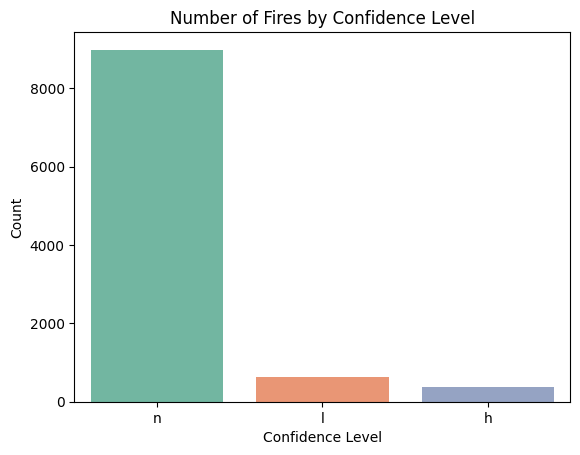

In [5]:
#visualization
# Count of risk categories-barchart
sns.countplot(x='confidence', data=df, palette='Set2')
plt.title("Number of Fires by Confidence Level")
plt.xlabel("Confidence Level")
plt.ylabel("Count")
plt.show()


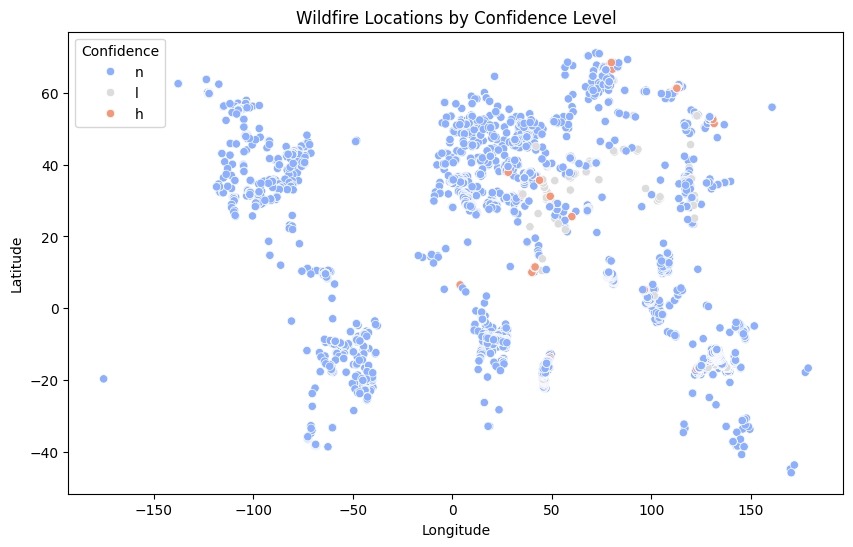

In [6]:
# Visualize location of fires (color by risk)
plt.figure(figsize=(10,6))
sns.scatterplot(x='longitude', y='latitude', hue='confidence', data=df, palette='coolwarm')
plt.title("Wildfire Locations by Confidence Level")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(title="Confidence")
plt.show()


/tmp/ipython-input-7-593344328.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='confidence', y='frp', data=df, palette='muted')


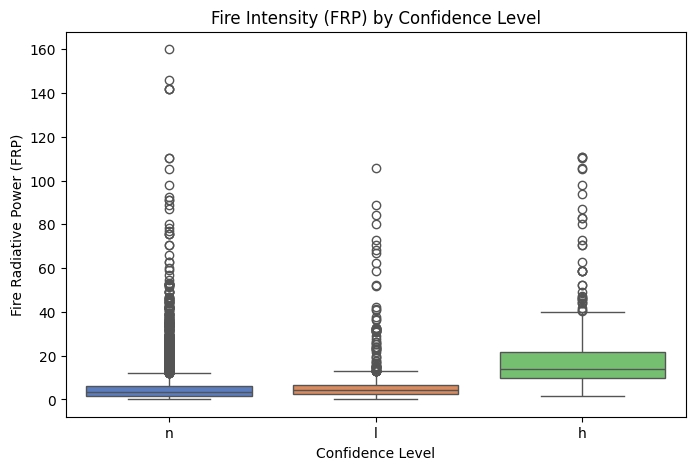

In [7]:
plt.figure(figsize=(8,5))
sns.boxplot(x='confidence', y='frp', data=df, palette='muted')
plt.title("Fire Intensity (FRP) by Confidence Level")
plt.xlabel("Confidence Level")
plt.ylabel("Fire Radiative Power (FRP)")
plt.show()


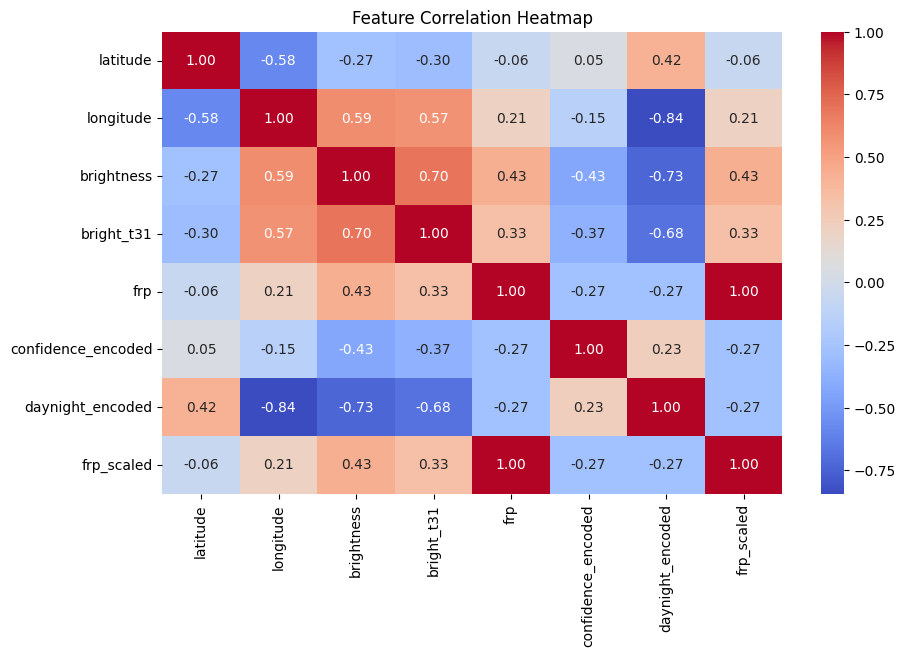

In [8]:
# Compute correlation only for numeric fields
plt.figure(figsize=(10,6))
numeric_df = df.select_dtypes(include=np.number)
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

In [9]:
#Step-5 train-test split
X_train, X_test, y_frp_train, y_frp_test = train_test_split(X, y_frp, test_size=0.2, random_state=42)
_, _, y_risk_train, y_risk_test = train_test_split(X, y_risk, test_size=0.2, random_state=42)


In [10]:
#STEP 6-DEFINE TIMER FUNCTION
def measure_training_time(model, X, y):
    start = time.time()
    model.fit(X, y)
    end = time.time()
    return round(end - start, 2)


In [11]:
# Add these imports at the very top of your notebook if not already there ---
import time
from joblib import Parallel, delayed # Make sure this is imported


# PASTE THIS CODE BLOCK DIRECTLY AFTER YOUR DATA SPLITTING (train_test_split)

print("\n--- Model Training & Evaluation ---")

# 1. Non-Parallel (Normal) Random Forest
print("\nRunning Non-Parallel Random Forest (n_jobs=1)...")
model_normal = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=1)

start_time_normal_train = time.time()
model_normal.fit(X_train, y_risk_train)
end_time_normal_train = time.time()
train_time_normal = end_time_normal_train - start_time_normal_train

start_time_normal_predict = time.time()
y_pred_normal = model_normal.predict(X_test)
end_time_normal_predict = time.time()
predict_latency_normal = (end_time_normal_predict - start_time_normal_predict) * 1000 / len(X_test)

accuracy_normal = accuracy_score(y_risk_test, y_pred_normal)
report_normal = classification_report(y_risk_test, y_pred_normal)

print(f"Non-Parallel Training Time: {train_time_normal:.2f} seconds")
print(f"Non-Parallel Prediction Latency (per sample): {predict_latency_normal:.2f} ms")
print(f"Non-Parallel Accuracy: {accuracy_normal:.4f}")
# print("\nNon-Parallel Classification Report:\n", report_normal) # Uncomment if you want to see the full report here


# 2. Parallel Random Forest
print("\nRunning Parallel Random Forest (n_jobs=-1)...")
model_parallel = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1) # -1 uses all available CPU cores

start_time_parallel_train = time.time()
model_parallel.fit(X_train, y_risk_train)
end_time_parallel_train = time.time()
train_time_parallel = end_time_parallel_train - start_time_parallel_train

start_time_parallel_predict = time.time()
y_pred_parallel = model_parallel.predict(X_test)
end_time_parallel_predict = time.time()
predict_latency_parallel = (end_time_parallel_predict - start_time_parallel_predict) * 1000 / len(X_test)

accuracy_parallel = accuracy_score(y_risk_test, y_pred_parallel)
report_parallel = classification_report(y_risk_test, y_pred_parallel)

print(f"Parallel Training Time: {train_time_parallel:.2f} seconds")
print(f"Parallel Prediction Latency (per sample): {predict_latency_parallel:.2f} ms")
print(f"Parallel Accuracy: {accuracy_parallel:.4f}")
# print("\nParallel Classification Report:\n", report_parallel) # Uncomment if you want to see the full report here


# 3. Final Comparison Summary
print("\n--- Performance Summary (Parallel vs. Non-Parallel) ---")
print(f"Training Time Speedup: {train_time_normal / train_time_parallel:.2f}x (lower is better for time)")
print(f"Prediction Latency Speedup: {predict_latency_normal / predict_latency_parallel:.2f}x (lower is better for latency)")
print(f"Accuracy (Normal): {accuracy_normal:.4f}")
print(f"Accuracy (Parallel): {accuracy_parallel:.4f}")




--- Model Training & Evaluation ---

Running Non-Parallel Random Forest (n_jobs=1)...
Non-Parallel Training Time: 0.47 seconds
Non-Parallel Prediction Latency (per sample): 0.01 ms
Non-Parallel Accuracy: 1.0000

Running Parallel Random Forest (n_jobs=-1)...
Parallel Training Time: 0.41 seconds
Parallel Prediction Latency (per sample): 0.08 ms
Parallel Accuracy: 1.0000

--- Performance Summary (Parallel vs. Non-Parallel) ---
Training Time Speedup: 1.15x (lower is better for time)
Prediction Latency Speedup: 0.08x (lower is better for latency)
Accuracy (Normal): 1.0000
Accuracy (Parallel): 1.0000


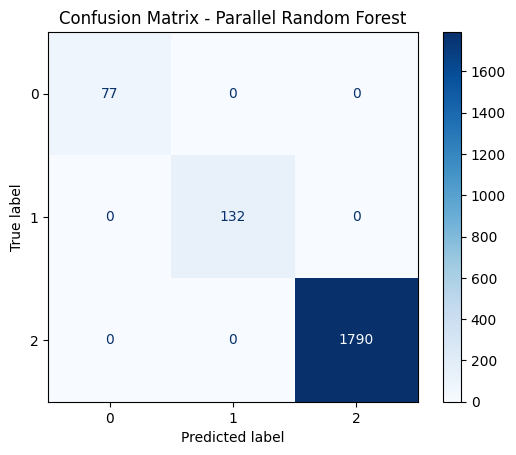

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Confusion Matrix for Parallel RF
cm = confusion_matrix(y_risk_test, y_pred_parallel)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_parallel.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Parallel Random Forest")
plt.show()


In [13]:

# 3. Final Comparison Summary
print("\n--- Performance Summary (Parallel vs. Non-Parallel) ---")
print(f"Training Time Speedup: {train_time_normal / train_time_parallel:.2f}x (lower is better for time)")
print(f"Prediction Latency Speedup: {predict_latency_normal / predict_latency_parallel:.2f}x (lower is better for latency)")
print(f"Accuracy (Normal): {accuracy_normal:.4f}")
print(f"Accuracy (Parallel): {accuracy_parallel:.4f}")




--- Performance Summary (Parallel vs. Non-Parallel) ---
Training Time Speedup: 1.15x (lower is better for time)
Prediction Latency Speedup: 0.08x (lower is better for latency)
Accuracy (Normal): 1.0000
Accuracy (Parallel): 1.0000


In [14]:
# --- STEP 7: Alert System (Using y_pred_parallel from the efficient model) ---
# Trigger alert if any predictions are "high risk" (encoded as 2)
high_risk_threshold = 2
high_risk_count = np.sum(y_pred_parallel == high_risk_threshold) # <--- This now uses y_pred_parallel

if high_risk_count > 0:
    print(f"\nALERT: {high_risk_count} high wildfire risk zones detected based on Parallel RF model!")
else:
    print("\nNo high-risk fires detected by Parallel RF model.")




ALERT: 1790 high wildfire risk zones detected based on Parallel RF model!


In [15]:
# Spark MLlib Parallel Random Forest Implementation
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier as SparkRF
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import pyspark.sql.functions as F

# Initialize Spark Session
spark = SparkSession.builder.appName("WildfireRiskPrediction").getOrCreate()

# Convert Pandas DataFrame to Spark DataFrame
spark_df = spark.createDataFrame(df)

# Select features and target for Spark
assembler = VectorAssembler(inputCols=['latitude', 'longitude', 'brightness', 'confidence_encoded', 'daynight_encoded'], outputCol="features")
spark_df = assembler.transform(spark_df)
spark_df = spark_df.withColumnRenamed("confidence_encoded", "label")

# Split into train/test
train_data, test_data = spark_df.randomSplit([0.8, 0.2], seed=42)

# Train Spark Random Forest model
spark_rf = SparkRF(numTrees=100, maxDepth=10, seed=42)

start_time_spark = time.time()
spark_model = spark_rf.fit(train_data)
end_time_spark = time.time()
train_time_spark = end_time_spark - start_time_spark

# Predict and evaluate
predictions = spark_model.transform(test_data)
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
spark_accuracy = evaluator.evaluate(predictions)

print("\n--- Spark MLlib Random Forest ---")
print(f"Spark Training Time: {train_time_spark:.2f} seconds")
print(f"Spark Accuracy: {spark_accuracy:.4f}")


--- Spark MLlib Random Forest ---
Spark Training Time: 31.65 seconds
Spark Accuracy: 1.0000


In [16]:
spark.sparkContext.setLogLevel("INFO")  # Or "DEBUG" to see more



=== Performance Comparison ===
                Method  Accuracy  Time (sec) Speedup
0  CPU Multiprocessing       1.0    0.410344       -
1                Spark       1.0   31.651319   0.01x


/tmp/ipython-input-17-3359136732.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Method', y='Time (sec)', data=comparison_df, palette="pastel")
/tmp/ipython-input-17-3359136732.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Method', y='Accuracy', data=comparison_df, palette="muted")


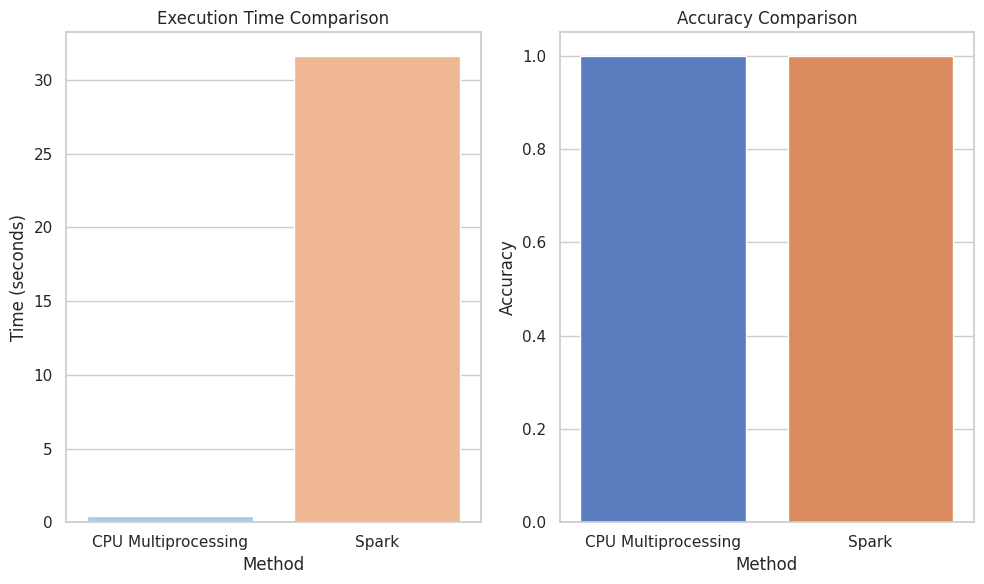

In [17]:
# PERFORMANCE COMPARISON
print("\n=== Performance Comparison ===")

# Create base comparison data
comparison_data = {
    'Method': ['CPU Multiprocessing', 'Spark'],
    'Accuracy': [accuracy_parallel, spark_accuracy],
    'Time (sec)': [train_time_parallel, train_time_spark],
    'Speedup': ['-', f"{train_time_parallel/train_time_spark:.2f}x"]
}

# Convert to DataFrame
comparison_df = pd.DataFrame(comparison_data)
print(comparison_df)

#  VISUALIZATION

# Set up plot styling
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Bar plot for Time
plt.subplot(1, 2, 1)
sns.barplot(x='Method', y='Time (sec)', data=comparison_df, palette="pastel")
plt.title('Execution Time Comparison')
plt.ylabel('Time (seconds)')

# Bar plot for Accuracy
plt.subplot(1, 2, 2)
sns.barplot(x='Method', y='Accuracy', data=comparison_df, palette="muted")
plt.title('Accuracy Comparison')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()